# LowHighRegression Feature engineering model selection


To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
# %pip install plotly==5.9.0
# %pip install twisted
# %pip install binance-connector==1.13.0
# %pip install pandas
# %pip install scikit-learn
#%pip install tensorflow==2.16.1
#%pip install keras==3.3.3
#%pip install keras==2.11.0
#%pip install scrapy==2.11.2
#%pip install itemloaders==1.2.0
# %pip install keras
# %pip install scikeras
# %pip install keras-tuner
# %pip install boto3
#%pip install python-dotenv
# %pip install xgboost
#%pip install catboost
# %pip install pmdarima

import os
import sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
# Read .env variable with s3 access keys
#%load_ext dotenv
#%dotenv

## App parameters

In [2]:
# env file
#env_file='local.env'
env_file='.env'
from dotenv import load_dotenv
dotenv_path = os.path.abspath(env_file) #travels up a level to find the .env
load_dotenv(dotenv_path)


ticker="BTC-USDT"
data_dir='./data'
history_days=360

# Features: how much candles of each period to include
features_candles_periods = ['10min', '15min', '30min', '60min']
target_period = '15min'
profit_loss_ratio = 3.5


test_days = 15

take_profit_min_coeff = 0.0012
stop_loss_max_coeff = 0.0048
# 0.001 = 60 for price=60K
stop_loss_add_ratio = 0.0002
take_profit_max_coeff = 0.005
stop_loss_min_coeff = 0.00012
comission_pct = 0.012
price_precision = 2
is_trailing_stop = True

comission_pct = 0.012
price_precision = 2

comission = 0.01 * comission_pct

experiment_name = 'LowHighRegression'
run_name =  f'LHR target: {target_period}, sharp: {profit_loss_ratio}, periods:{features_candles_periods},  history {history_days}, test {test_days}'
do_log_experiment = False
do_log_model = False



In [3]:
# Indicators' params for each candle period
features_params = {
    "5min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "10min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "20min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "30min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "40min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
}
features_params = None
# Default
#features_params = None
# features_params = {
#     "5min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
#     "10min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
#     "20min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
#     "30min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
#     "40min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
# }

## Feature engineering
Read data from bot's history, resample to equal intervals, create X, y

### Read candles from history

In [4]:
from tools.DataTool import DataTool
candles_1min = DataTool.read_last_candles(ticker, os.path.join(data_dir, "candles"), history_days)
candles_1min.tail()

close_time           open_time    ticker interval     open     high      low    close   vol
close_time                                                                                                              
2024-06-07 16:06:00 2024-06-07 16:06:00 2024-06-07 16:05:00  BTC-USDT     1min  71002.2  71026.9  71002.1  71008.3  2994
2024-06-07 16:07:00 2024-06-07 16:07:00 2024-06-07 16:06:00  BTC-USDT     1min  71008.3  71022.1  70999.0  70999.0  2598
2024-06-07 16:08:00 2024-06-07 16:08:00 2024-06-07 16:07:00  BTC-USDT     1min  70989.0  71014.5  70967.1  71014.5  1706
2024-06-07 16:09:00 2024-06-07 16:09:00 2024-06-07 16:08:00  BTC-USDT     1min  71014.5  71034.1  71014.5  71034.1  2408
2024-06-07 16:10:00 2024-06-07 16:10:00 2024-06-07 16:09:00  BTC-USDT     1min  71034.1  71034.1  71034.1  71034.1    28

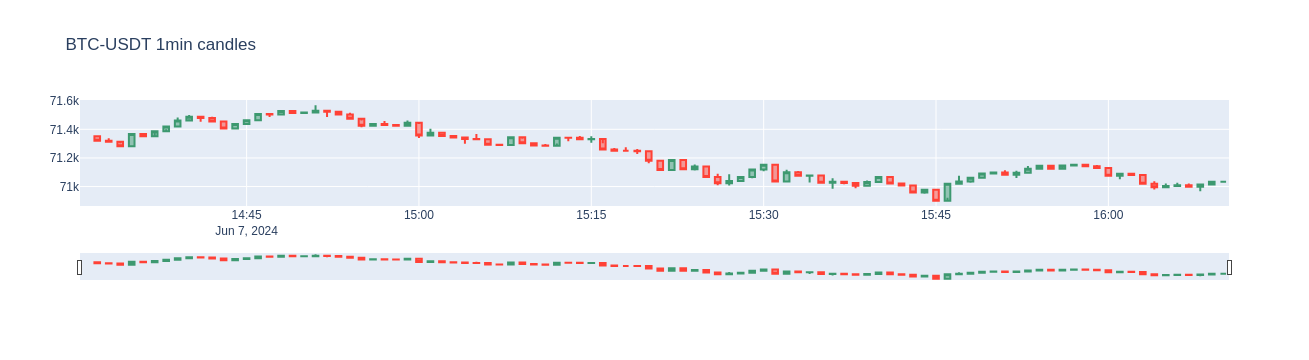

In [5]:
from tools.PlotTool import PlotTool
PlotTool.plot_candles(candles_1min.tail(100), '1min')

### Build features and targets

In [6]:
sys.path.append("pytrade2/pytrade2")
from pytrade2.pytrade2.strategy.features.CandlesFeatures import CandlesFeatures
from pytrade2.pytrade2.strategy.features.MultiIndiFeatures import MultiIndiFeatures
from pytrade2.pytrade2.strategy.features.LowHighTargets import LowHighTargets

def candles_by_periods_of(candles_1min: pd.DataFrame, periods) -> dict[str, pd.DataFrame]:
    """ Create candles_by_periods """
    out = {}
    for period in periods:
        out[period] = candles_1min.resample(period, closed='right').agg({'open_time': 'first',
                                                             'close_time': 'last',
                                                             'open': 'first',
                                                             'high': 'max',
                                                             'low': 'min',
                                                             'close': 'last',
                                                             'vol': 'max'
                                                        })
    return out
 
# Candles by periods dictionary
candles_by_period = candles_by_periods_of(candles_1min, features_candles_periods)
print('Candles counts: %s' % {period: len(df) for period, df in candles_by_period.items()})

# Features no diff

features = MultiIndiFeatures.multi_indi_features(candles_by_period, features_params)
targets = LowHighTargets.fut_lohi(candles_by_period[target_period], target_period)
features = features.dropna()
targets = targets.dropna()
features = features[features.index.isin(targets.index)]
targets = targets[targets.index.isin(features.index)]


Candles counts: {'10min': 51793, '15min': 34529, '30min': 17265, '60min': 8633}


In [7]:
#candles_1min.tail()


### Train test split

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

def create_pipe(x, y) -> (Pipeline, Pipeline):
    """ Create feature and target pipelines to use for transform and inverse transform """

    time_cols = [col for col in x.columns if col.startswith("time")]
    float_cols = list(set(x.columns) - set(time_cols))

    x_pipe = Pipeline(
        [("xscaler", ColumnTransformer([("xrs", StandardScaler(), float_cols)], remainder="passthrough")),
         ("xmms", MaxAbsScaler())])
    x_pipe.fit(x)

    y_pipe = Pipeline(
        [("yrs", StandardScaler()),
         ("ymms", MaxAbsScaler())])
    y_pipe.fit(y)
    return x_pipe, y_pipe


In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt


def train_test_split(x, y, test_days=14):
    """ In addition to train_test_split, create pipeline for reverse transform in future"""
    #test_index = int(len(x)*(1-test_size))
    
    test_index = max(x.index) - pd.Timedelta(days=test_days)
    is_test = (x.index >= test_index)
    is_train = (x.index < test_index)
    
    x_train, y_train, x_test, y_test = x[is_train], y[is_train], \
        x[is_test], y[is_test]

    # Create pipeline to transform/reverse transform
    x_pipe, y_pipe = create_pipe(x_train, y_train)
    return x_pipe, y_pipe, x_train, y_train, x_test, y_test


x_pipe, y_pipe, x_train, y_train, x_test, y_test = train_test_split(features, targets, test_days=test_days)

## Model creation and training

### Create model list to compare

In [10]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from pmdarima import auto_arima
from pmdarima.arima import AutoARIMA, ARIMA
  
# Ignore harmless warnings 
#import warnings 
#warnings.filterwarnings("ignore") 

# Final features transformation from pandas to ndarray
x_train_prep = x_pipe.transform(x_train)
y_train_prep = y_pipe.transform(y_train)
x_test_prep = x_pipe.transform(x_train)
y_test_prep = y_pipe.transform(y_train)

# Create models under test
models = [('LGBM', MultiOutputRegressor(lgb.LGBMRegressor(**{'learning_rate':0.1}))),
          ('XGB', MultiOutputRegressor(XGBRegressor(objective='reg:squarederror'))),
          ('CatBoost',MultiOutputRegressor( CatBoostRegressor(verbose=0, n_estimators=100))),
          # ('LinearRegression', MultiOutputRegressor(LinearRegression())),
          # ('Lasso', MultiOutputRegressor(Lasso())),
          # ('ElasticNet', MultiOutputRegressor(ElasticNet())),
          # ('ARDRegression', MultiOutputRegressor(ARDRegression())),
          # ('SGDRegressor', MultiOutputRegressor(SGDRegressor())),
          ('KNEighborsRegressor', MultiOutputRegressor(KNeighborsRegressor()))
         ]


2024-06-08 00:03:13.645512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 00:03:14.802284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Fit, predict

In [11]:
def fit_predict_lgb(model):
    # x_train_prep = x_pipe.transform(x_train)
    # y_train_prep = y_pipe.transform(y_train)
    # x_test_prep = x_pipe.transform(x_train)
    # y_test_prep = y_pipe.transform(y_train)
    # Normal MultiOutputRegressor fit
    model.fit(x_train_prep,
              y_train_prep, 
              feature_name = x_train.columns.tolist(),
            eval_set=[(x_train_prep,y_test_prep[:,0]),(x_train_prep, y_test_prep[:,1])]
             )
    
    # Fit estimators separately to plot separate metrics
    for i,name in enumerate(y_train.columns.tolist()):
        model.estimators_[i].fit(x_train_prep,
                y_train_prep[:,i], 
                feature_name = x_train.columns.tolist(),
                # eval_set=[(x_train_prep,y_train_prep[:,i]), (x_test_prep,y_test_prep[:,i])]
                eval_set=[(x_train_prep,y_train_prep[:,i])]
                 )
        lgb.plot_metric(model.estimators_[i], title = f'{name} LightGBM metric')
    # Plot importances
    for i,name in enumerate(y_train.columns.tolist()):
        lgb.plot_importance(model.estimators_[i], importance_type="gain", figsize=(7,16), title=f"{name} LightGBM Feature Importance (Gain)")
    
    #Predict and inverse transform to dataframe
    y_pred = model.predict(x_pipe.transform(x_test))
    y_pred = y_pipe.inverse_transform(y_pred)
    y_pred = pd.DataFrame(y_pred, columns = y_test.columns, index = y_test.index)
    return y_pred

def fit_predict(name, model):
    print(f'Fit predict model: {model}')
    model.fit(x_train_prep,
              y_train_prep
             )
    
    #Predict and inverse transform to dataframe
    y_pred = model.predict(x_pipe.transform(x_test))
    y_pred = y_pipe.inverse_transform(y_pred)
    y_pred = pd.DataFrame(y_pred, columns = y_test.columns, index = y_test.index)
    return y_pred


# List of (model name, prediction) tuples
y_preds = [(name, fit_predict(name, model)) for name, model in models]


Fit predict model: MultiOutputRegressor(estimator=LGBMRegressor())
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9208
[LightGBM] [Info] Number of data points in the train set: 32987, number of used features: 38
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9208
[LightGBM] [Info] Number of data points in the train set: 32987, number of used features: 38
[LightGBM] [Info] Start training from score 0.000000
Fit predict model: MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                          

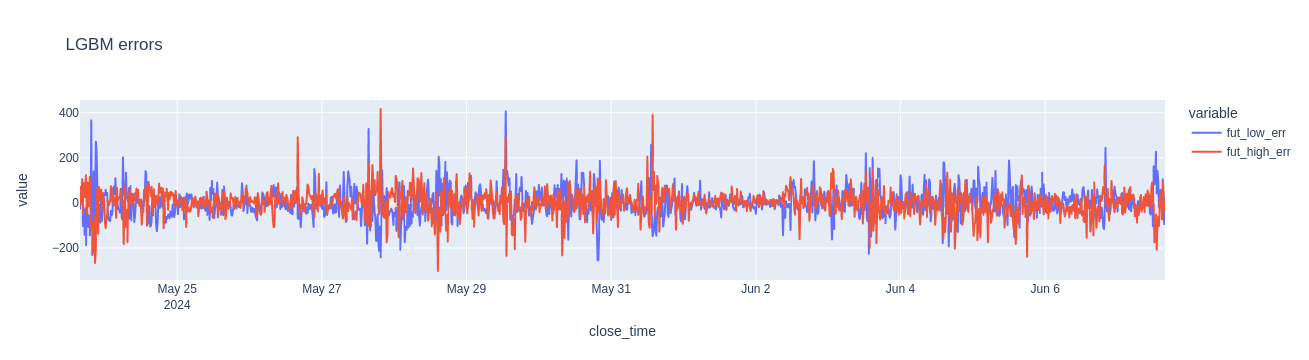

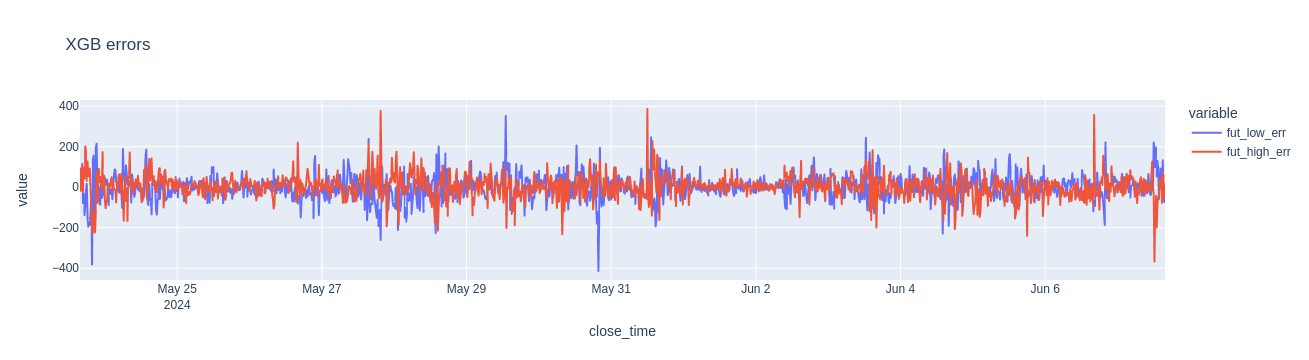

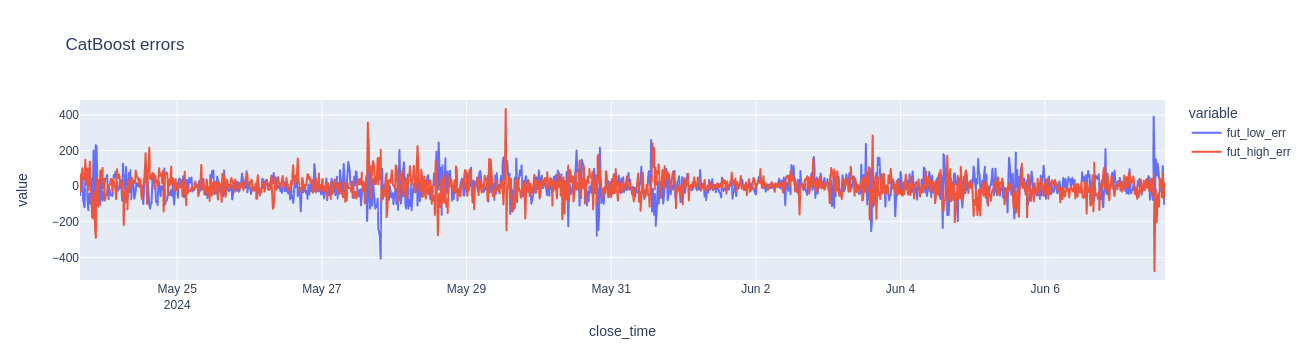

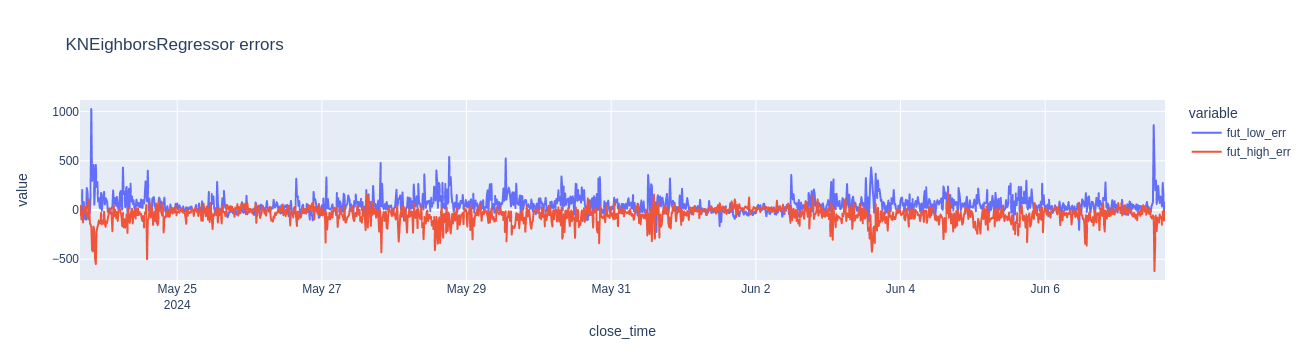

In [12]:
import plotly as py
import plotly.express as px
from plotly import graph_objects as go
# Remove plotly warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_y_pred_err(y_test, y_pred, name):
    """ Plot error: delta between predicted and expected """
    err = pd.DataFrame()
    err['fut_low_err'] = y_pred['fut_low_diff'] - y_test['fut_low_diff']
    err['fut_high_err'] = y_pred['fut_high_diff'] - y_test['fut_high_diff']
    px.line(err, title=f'{name} errors').show()

for name, y_pred in y_preds:
    plot_y_pred_err(y_test, y_pred, name)


# Evaluate the model

### Trading emulation

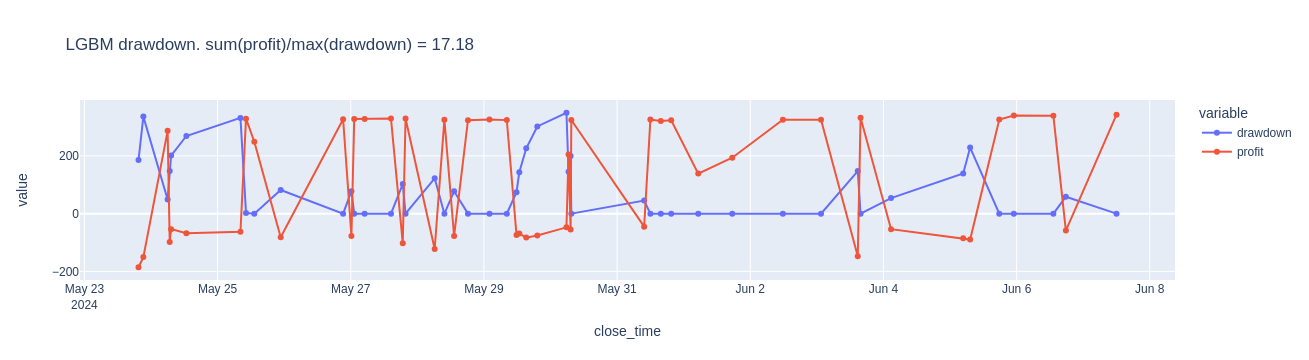

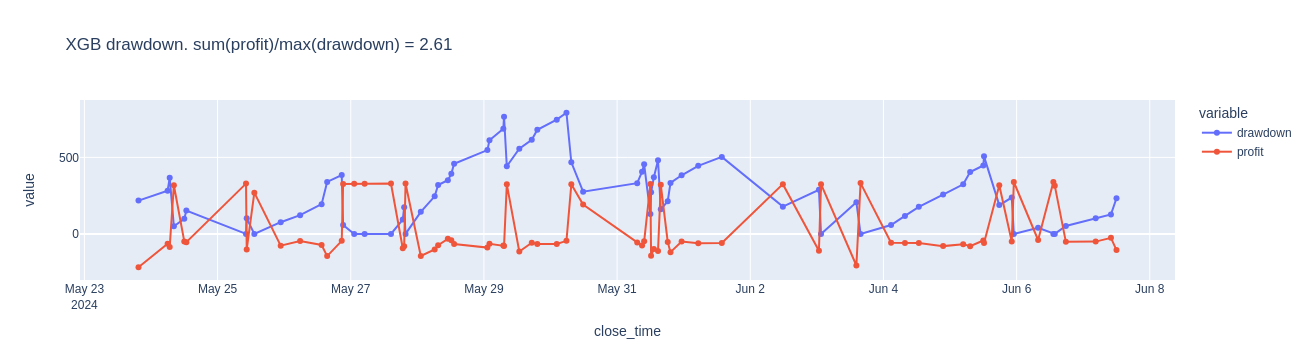

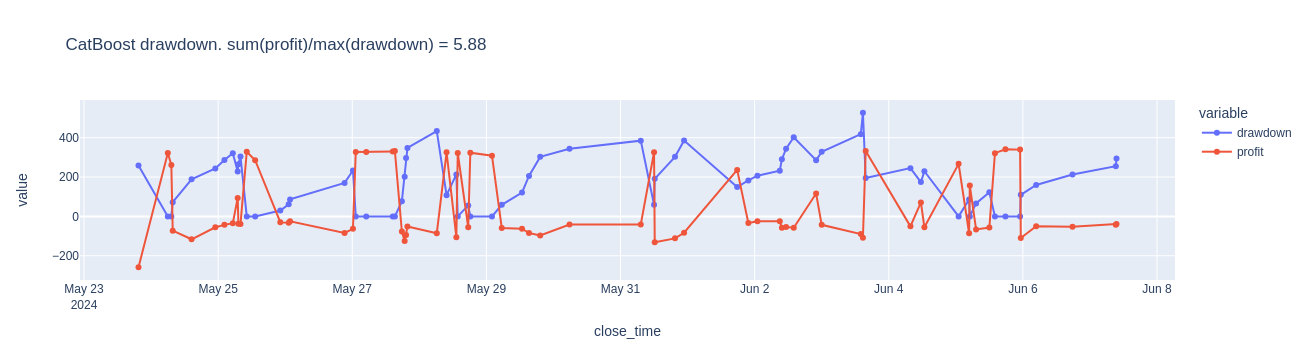

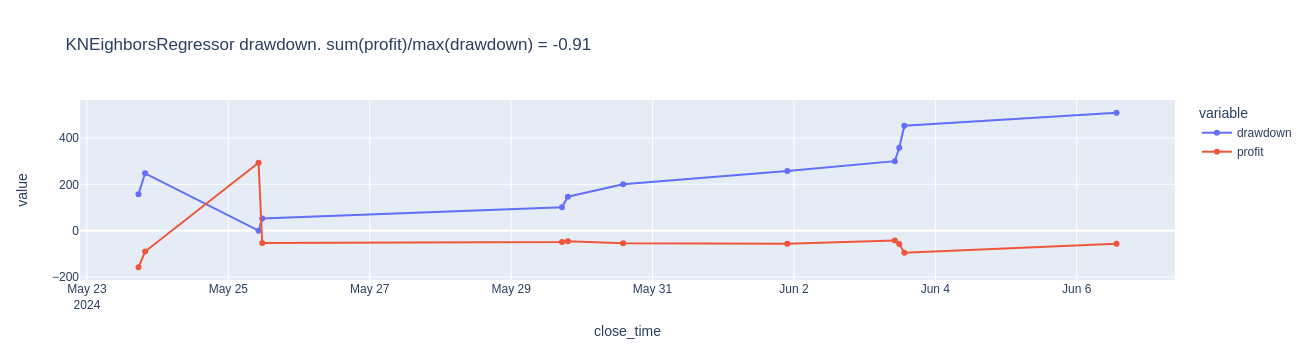

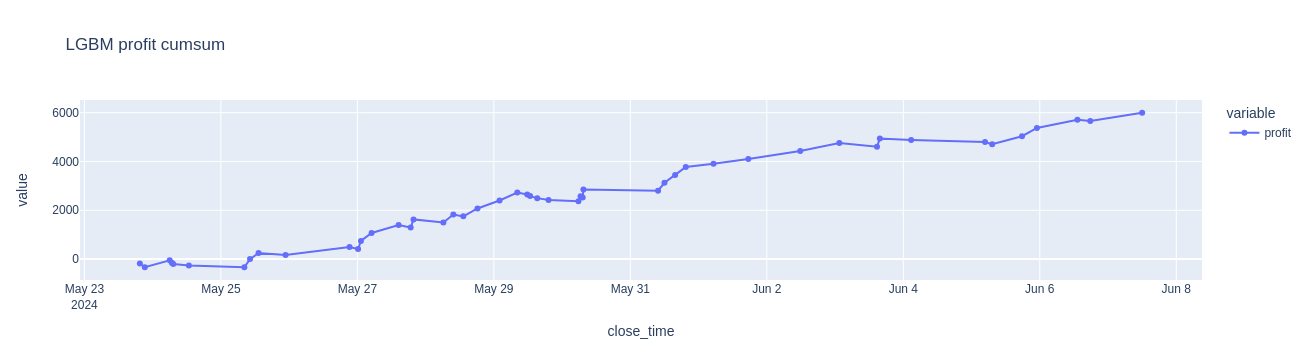

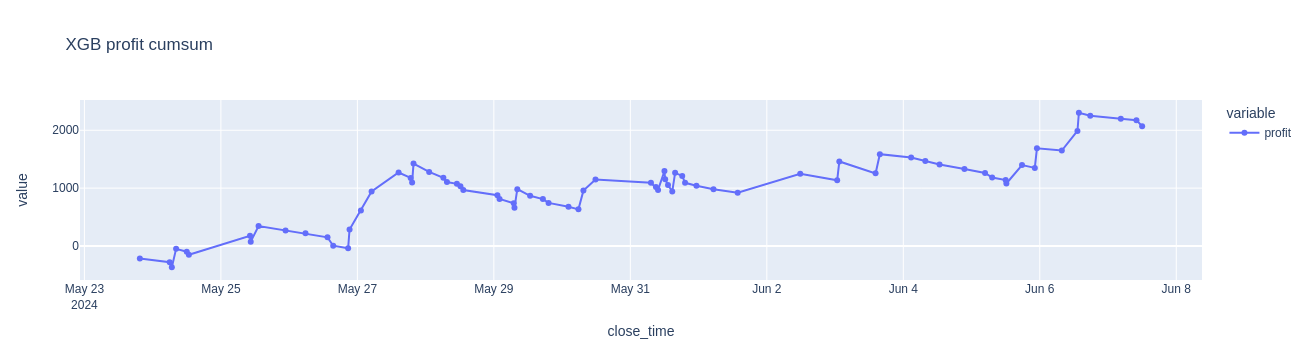

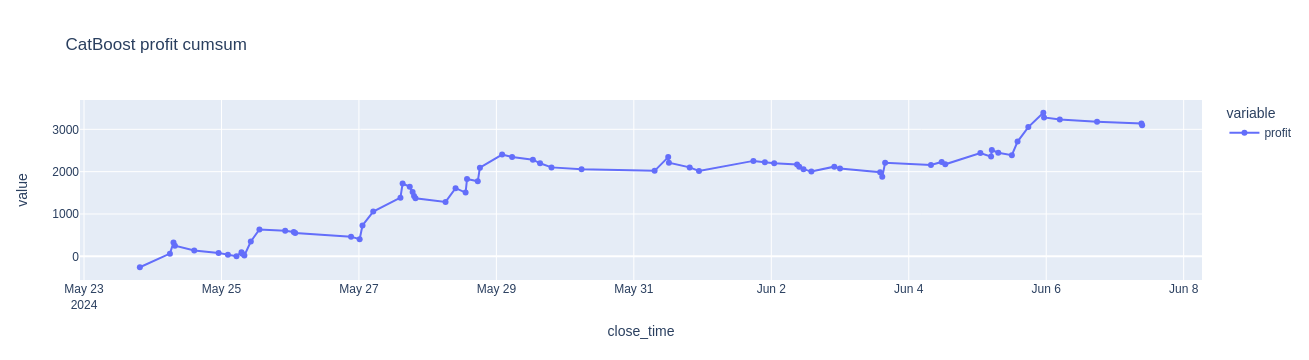

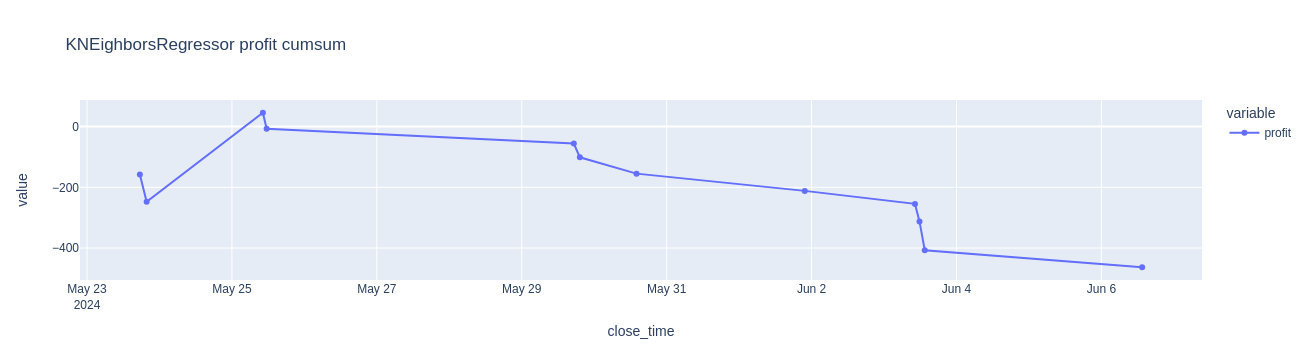

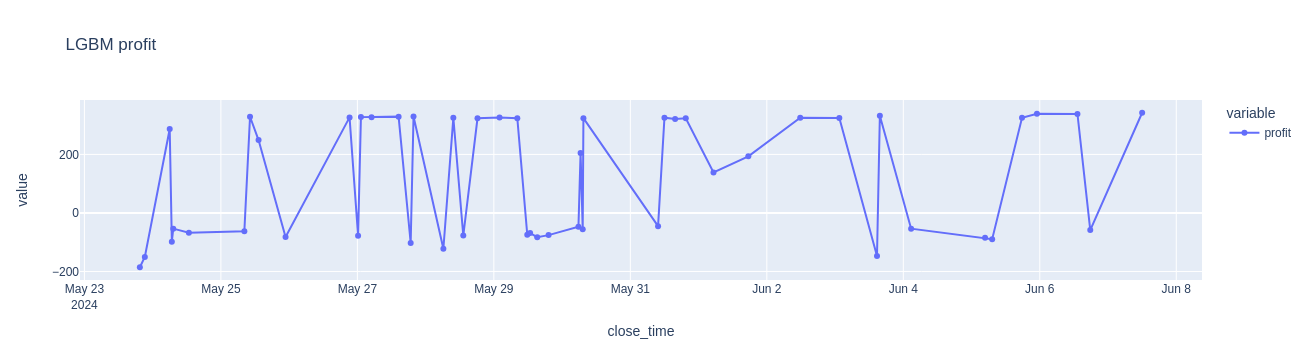

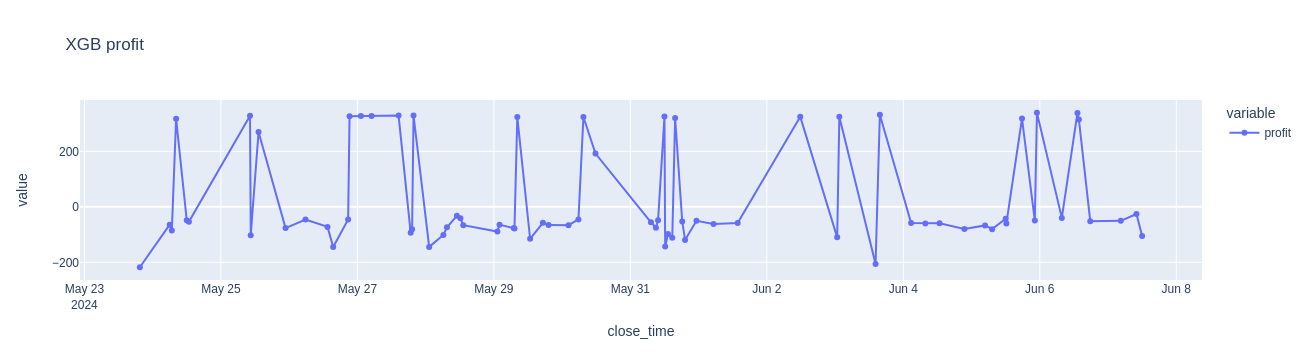

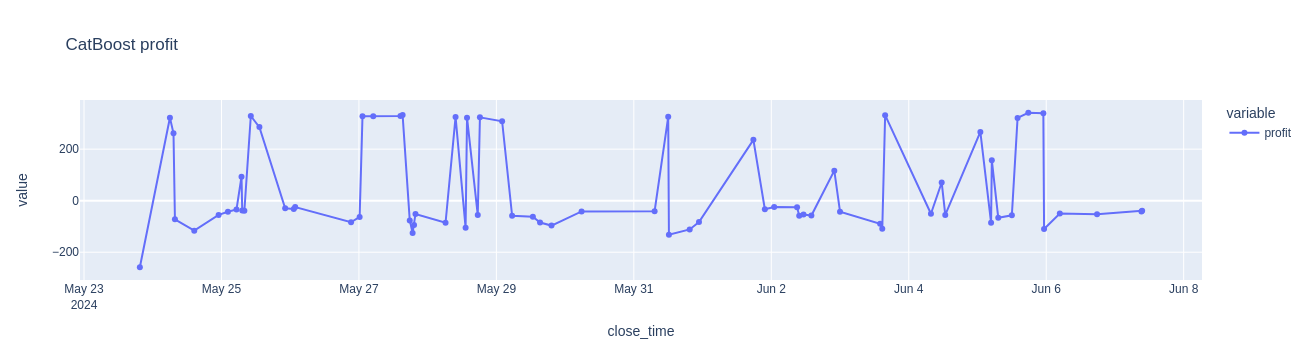

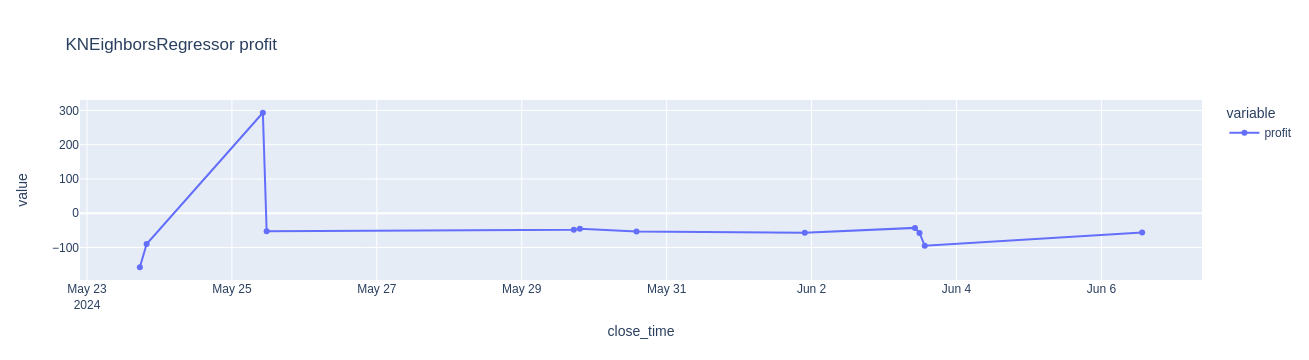

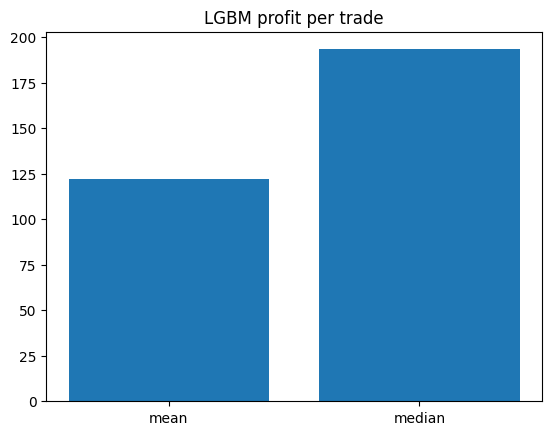

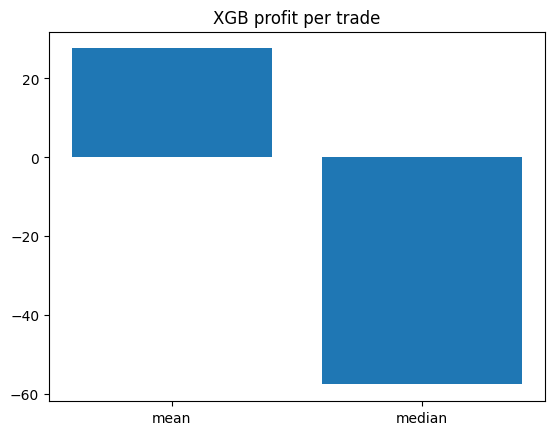

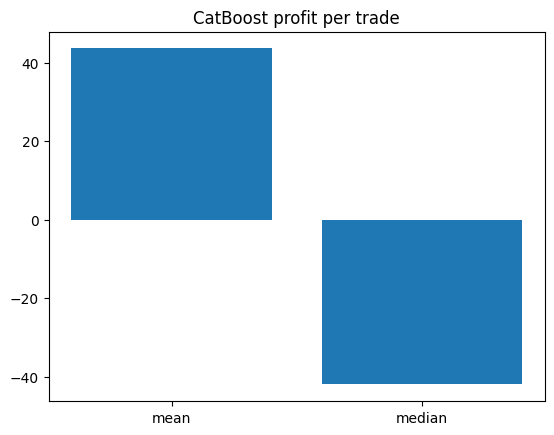

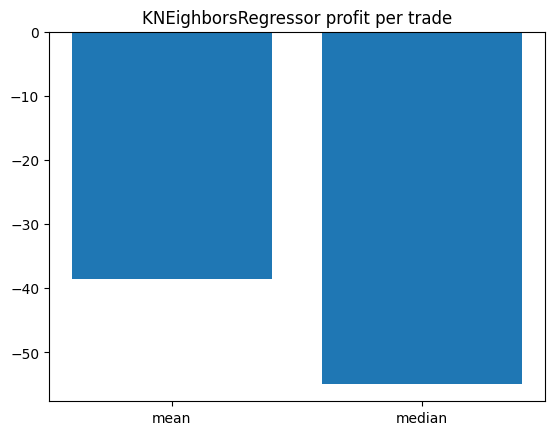

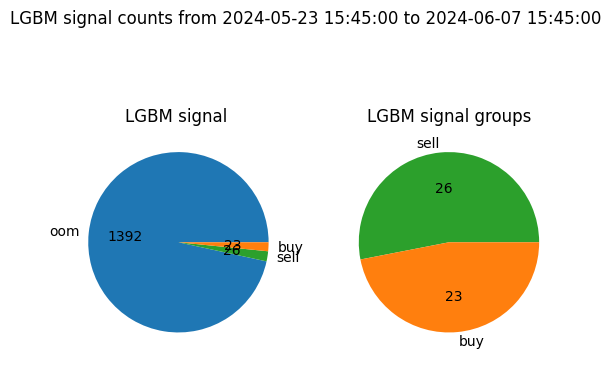

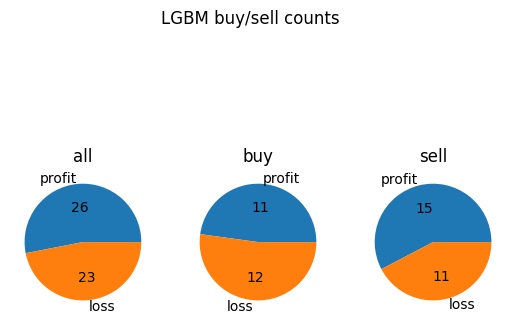

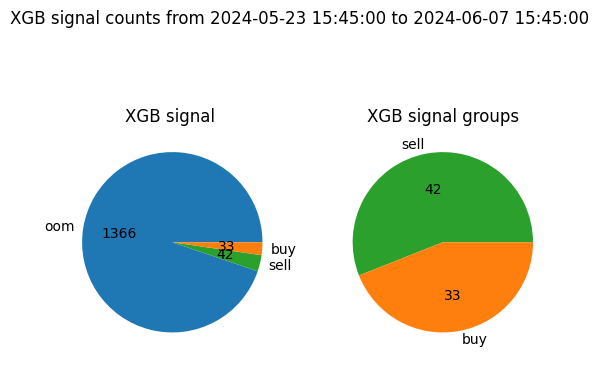

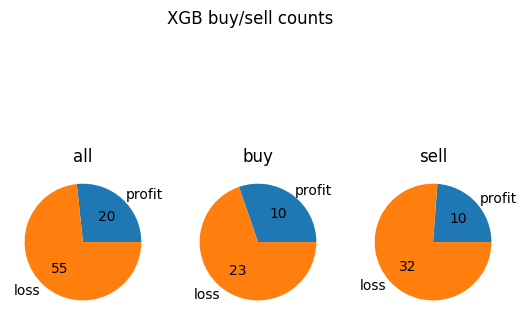

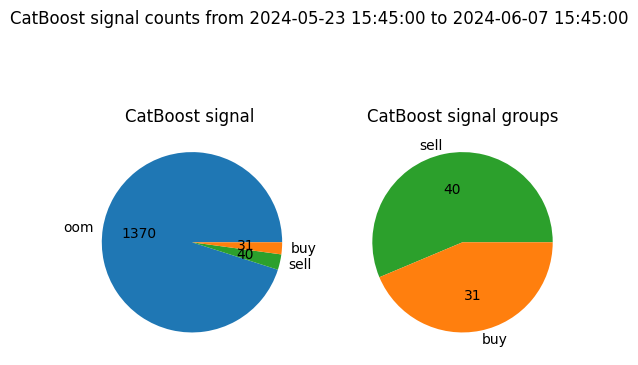

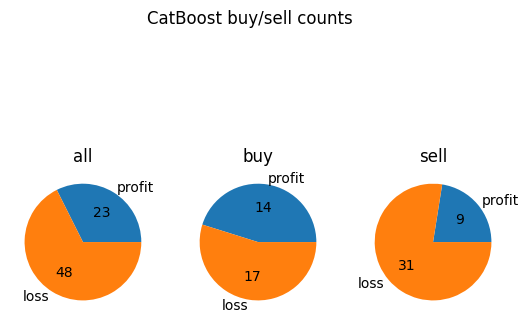

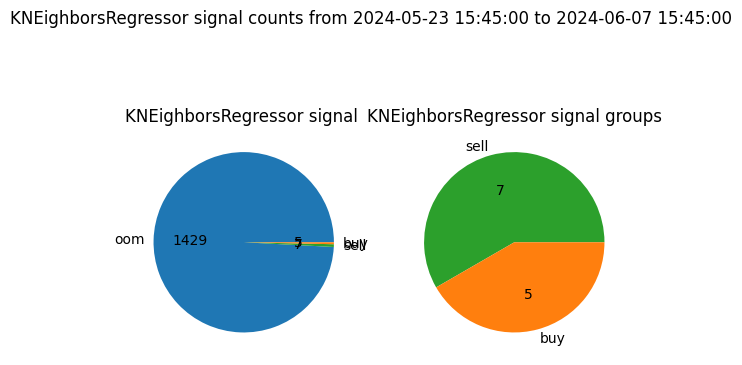

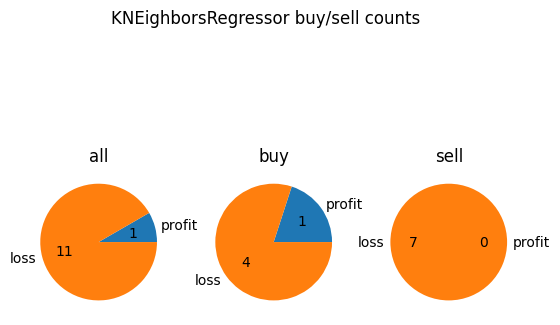

In [13]:
from pytrade2.pytrade2.strategy.signal.SignalByFutLowHigh import SignalByFutLowHigh
import seaborn as sns


def calc_signal_ext(candles, y_test, y_pred):
    """ Using predicted values, create dataframe with signal, stoploss, takeprofit """
    # Combine test with pred
    fut_df = pd.DataFrame(index = y_pred.index)
    fut_df['close'] = candles['close']
    fut_df['fut_low'] = candles['close'] + y_test['fut_low_diff']
    fut_df['fut_high'] = candles['close'] + y_test['fut_high_diff']
    fut_df['fut_low_pred'] = candles['close'] + y_pred['fut_low_diff']
    fut_df['fut_high_pred'] = candles['close'] + y_pred['fut_high_diff']

    # Signal calculator from pytrade2
    signal_calc = SignalByFutLowHigh(profit_loss_ratio=profit_loss_ratio,
                                stop_loss_min_coeff=stop_loss_min_coeff,
                                stop_loss_max_coeff=stop_loss_max_coeff,
                                stop_loss_add_ratio = stop_loss_add_ratio,
                                take_profit_min_coeff=take_profit_min_coeff,
                                take_profit_max_coeff=take_profit_max_coeff,
                                comission_pct=comission_pct,
                                price_presision=price_precision)
    
    # Create df: signal, stoploss, take profit
    signal_df = fut_df[['close', 'fut_low_pred', 'fut_high_pred']]\
            .apply(lambda row: signal_calc.calc_signal(row[0], row[1], row[2]), axis=1, result_type='expand')
    signal_df.columns = ['signal', 'sl', 'tp']    
    signal_df = pd.concat([signal_df, fut_df], axis=1)
    signal_df = with_profit(signal_df)
    signal_df = with_drawdown(signal_df)    
    return pd.concat([signal_df, fut_df], axis=1)
    
def with_profit(signal):
    """ Metric: profit it trade by predicted values """

    # Buy and price keeps above stop loss and goes over tp
    is_buy_profit = (signal['signal'] == 1) & (signal['fut_low'] > signal['sl']) & (signal['fut_high'] >= signal['tp'])
    is_buy_loss = (signal['signal'] == 1) & (~is_buy_profit)
    
    # Sell and price keeps below stop loss and goes below tp
    is_sell_profit = (signal['signal'] == -1) & (signal['fut_high'] < signal['sl']) & (signal['fut_low'] <= signal['tp'])
    is_sell_loss = (signal['signal'] == -1) & (~is_sell_profit)

    #profit = pd.DataFrame(index = signal.index)
    signal['profit'] = 0

    # Buy profit or loss
    signal.loc[is_buy_profit, 'profit'] = signal['tp'] - signal['close'] - (signal['tp']*comission) - (signal['close']*comission)
    signal.loc[is_buy_loss, 'profit'] = signal['sl'] - signal['close'] - (signal['sl']*comission) - (signal['close']*comission)

    # Sell profit or loss
    signal.loc[is_sell_profit, 'profit'] = signal['close'] - signal['tp'] - (signal['close']*comission) - (signal['tp']*comission)
    signal.loc[is_sell_loss, 'profit'] = signal['close'] - signal['sl'] - (signal['close']*comission) - (signal['sl']*comission)
    
    return signal

def with_drawdown(df):
    # todo: remove -10
    #profits = df.loc[df['profit'] != 0, 'profit'][:-10]
    profits = df['profit']
    max_drawdown = 0
    cur_drawdown = 0
    drawdowns = []
        
    for profit in profits.values:
        if profit < 0:
            # Loss - increase drawdown
            cur_drawdown -= profit # increase drawdown
        else:
            # We have profit! Decrease drowdown, or if profit covered previous drawdown, set drawdown to 0.
            cur_drawdown = max(0, cur_drawdown - profit)
        max_drawdown = max(max_drawdown, cur_drawdown)
        drawdowns.append(cur_drawdown)

    df['drawdown'] = drawdowns
    return df

def plot_drawdown(signal_ext, name):
    drawdown = max(signal_ext['drawdown'])
    profit = sum(signal_ext['profit'])
    ratio = profit/drawdown if drawdown != 0 else profit * drawdown
    ratio = round(ratio, 2)
    title = f'{name} drawdown. sum(profit)/max(drawdown) = {ratio}'
    px.line(signal_ext.loc[signal_ext['signal']!=0, ['drawdown', 'profit']], title = title).update_traces(mode='lines+markers').show()

def profit_per_trade_barplot(signal_ext, name):
    profit_df = signal_ext.loc[signal_ext['profit']!=0, 'profit']
    mean = profit_df.mean()
    median = profit_df.median()

    plt.bar(x=["mean", "median"], height=[mean, median])
    plt.title(f'{name} profit per trade');
    plt.show()

# Signals array of each model: (name, signal_ext df)
signals_ext = [(name, calc_signal_ext(candles_by_period[target_period], y_test, y_pred)) for name, y_pred in y_preds]

for name, signal_ext in signals_ext:
    # Drawdown plot
    plot_drawdown(signal_ext, name)
    
for name, signal_ext in signals_ext:
    # Profit cumsumplot
    px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'].cumsum(), title = f'{name} profit cumsum').update_traces(mode='lines+markers').show()

for name, signal_ext in signals_ext:
    # Profit plot
    px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'], title = f'{name} profit').update_traces(mode='lines+markers').show()
    
for name, signal_ext in signals_ext:
    # Mean, median profit per trade
    profit_per_trade_barplot(signal_ext, name)

for name, signal_ext in signals_ext:
    # How many signals total
    PlotTool.plot_signal_counts(signal_ext, name)
    PlotTool.plot_buy_sell(signal_ext, name)